# Lecture 2

**Overview**
1. Taking Samples
    * Variation of samples 
    * The $1/\sqrt{n}$ law
2. Distributions
    * densities
    * ecdfs
3. Parametric ("analytic") versus nonparametric ("hacker statistics")
    * Confidence Intervals
    * Testing
4. Resampling
    * Permutations
    * Bootstrap

**Importing libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random 
random.seed(42) #What is this for ???

--------
**Importing the Birthweights Dataframe**

In [5]:
df = pd.read_csv('../data/BirthWeights.csv')[["sex", "dbirwt"]]
df.head()

,sex,dbirwt
0,male,2551
1,male,2778
2,female,2976
3,female,3345
4,female,3175


---------
## Operator Overloading

The [] operator is overloaded. This means, that depending on the inputs, pandas will do something completely different. Here are the rules for the different objects you pass to just the indexing operator.

* string — return a column as a Series
* list of strings — return all those columns as a DataFrame
* a slice — select rows (can do both label and integer location — confusing!)
* a sequence of booleans — select all rows where True

In summary, primarily just the indexing operator selects columns, but if you pass it a sequence of booleans it will select all rows that are `True`.

In [6]:
df = df[(df[ "dbirwt"] < 6000) & (df[ "dbirwt"] > 2000)] # 2000 < birthweight < 6000
df.head()

,sex,dbirwt
0,male,2551
1,male,2778
2,female,2976
3,female,3345
4,female,3175


---------
**Boxplot of weight vs. sex**

In [7]:
df.describe()

,dbirwt
count,4909.000000
mean,3480.557344
std,529.280103
min,2012.000000
25%,3146.000000
50%,3486.000000
75%,3827.000000
max,5981.000000


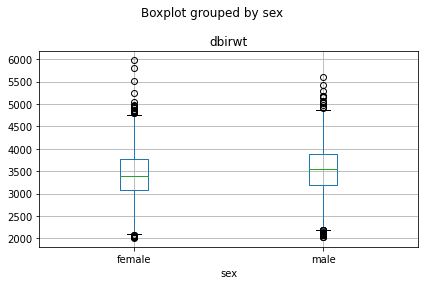

In [8]:
tmp=df.boxplot( "dbirwt","sex")
plt.tight_layout()

---------
**We notice a small difference in the average weight, which is more clearly visible when we plot overlaying densities for male/female**

In [9]:
bwghtBySex = np.round(df[["dbirwt","sex"]].groupby("sex")[["dbirwt"]].mean())

print(bwghtBySex, '\n')
print('mean: ',bwghtBySex.mean())

        dbirwt
sex           
female  3427.0
male    3533.0 

mean:  dbirwt    3480.0
dtype: float64


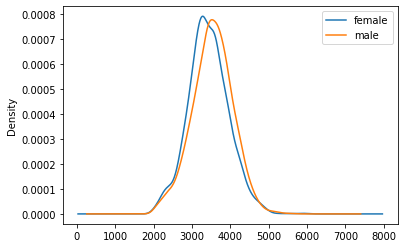

In [10]:
tmp=df[["dbirwt","sex"]].groupby("sex")["dbirwt"].plot(kind='density', legend=True)

-----------
## A/B Testing

Let us hypothesize that one wanted to classify babies into male/female solely based on their weight. What would its accuracy be if we applied the following simple rule:

if dbirwt > 3480 y = male else y = female

This would be the equivalent of testing for global warming by measuring the temperature on **one** day. We all know that it took a long time (= many samples) to reliably detect a small difference like 0.5 degrees buried in the noise. Let us apply the same idea here. Maybe we can build a high-accuracy classifier if we weighed enough babies separately for each sex.

In [17]:
df

,sex,dbirwt,pred_sex
0,male,2551,True
1,male,2778,True
2,female,2976,False
3,female,3345,False
4,female,3175,False
...,...,...,...
4995,male,4405,True
4996,male,2764,True
4997,female,2776,False
4998,female,3615,False


In [28]:
df["pred_sex"]=df["dbirwt"]>3480

In [29]:
df

,sex,dbirwt,pred_sex
0,male,2551,False
1,male,2778,False
2,female,2976,False
3,female,3345,False
4,female,3175,False
...,...,...,...
4995,male,4405,True
4996,male,2764,False
4997,female,2776,False
4998,female,3615,True


In [34]:
confmax = pd.crosstab(df["pred_sex"],df["sex"])
acc = (confmax.iloc[0,0]+confmax.iloc[1,1])/np.sum(df.shape[0])
acc

0.5508250152780607

----------
**Confusion Matrix for simple classifier**

In [8]:
df["predMale"] = df["dbirwt"] > 3480
pd.crosstab(df["predMale"], df["sex"])

sex,female,male
predMale,,
False,1331,1105
True,1100,1373


In [9]:
Acc0 = (1367+1377)/5000
print("Accuracy of lame classifier:", Acc0)
#Think about the baseline accuracy

Accuracy of lame classifier: 0.5488


--------------
## Distributions

### Mean Density Comparison Function

**Write a function which:**

1. draws repeated (e.g. M=500) random samples of size n (e.g. 40, 640) from each sex from the data
2. Computes the stdevs for the sample means of each sex separately
3. Repeats the above density plot for the sample mean distributions
4. computes the confusion matrix/accuracy of a classifier that applies the rule $\bar{x} > 3480$.

`Hint:
np.random.choice(df["dbirwt"],2)`

In [131]:
def rand_samples(df, M=500, n=10):
    
    #Create new empty df with columns sex and birthweight to store results
    df_results = pd.DataFrame(columns=["sex","dbirwt"])
    
    #Create bootstrap samples for both sexes and compute mean
    for i, sex in enumerate(["male","female"]):
        
        for j in range(M):
            results = np.random.choice((df[df["sex"]==sex]["dbirwt"]), n)
            df_results.loc[len(df_results)+1] = [sex, np.mean(results)]
    
        #plot male and female data and calculate the standard deviation of the data
        plot_data = df_results[df_results.sex == sex]
        
        plot_data.dbirwt.plot.density()
        plt.xlabel('dbirwt')
        plt.legend(["male","female"])
    
    return df_results

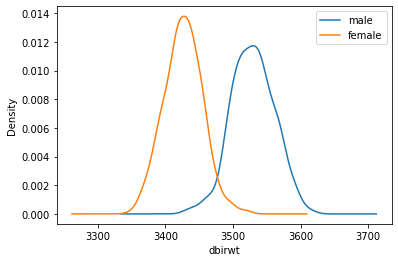

In [133]:
df_results = rand_samples(df, M=500, n=300)

In [73]:
def mean_density_comparison(df_cleaned, M=500, n=10):
    
    #Generate a sex iteration array
    sex_iter = ['male', 'female']
    
    #Create an empty DataFrame with 'sex' and 'dbirwt' column
    columns = ['sex', 'dbirwt']
    df_new = pd.DataFrame(columns=columns)
    
    #Create an empty array to store the standard deviation of the differnt sex 'male' = std_dev[0], 'female' = std_dev[1]
    std_dev = np.empty(2)
    
    #Iterate over sex and create a specific data subset
    for ind,v in enumerate(sex_iter):
        subset = df_cleaned[df_cleaned.sex == v]
        
        #create M random sample means of n samples and add it to df_new
        for i in range(M):
            rand_samples = np.random.choice(subset.dbirwt, n)
            x = np.mean(rand_samples)#sample mean per sexa
            df_new.loc[len(df_new)+1] = [v, x]
        
        #plot male and female data and calculate the standard deviation of the data
        plot_data = df_new[df_new.sex == v]
        std_dev[ind] = np.std(plot_data['dbirwt'])  

        
        plot_data.dbirwt.plot.density()
        plt.xlabel('dbirwt')
        plt.legend(sex_iter)
		#plt.grid()
		#plt.title("n=" + str(n))
		
    #return the sample mean data
    return df_new
 
        

------------
**Testing the Function**

      sex       dbirwt
1    male  3518.485938
2    male  3502.056250
3    male  3523.204688
4    male  3520.623437
5    male  3501.317187
..    ...          ...
496  male  3540.471875
497  male  3539.290625
498  male  3507.534375
499  male  3501.853125
500  male  3530.159375

[500 rows x 2 columns]
         sex       dbirwt
1       male  3518.485938
2       male  3502.056250
3       male  3523.204688
4       male  3520.623437
5       male  3501.317187
...      ...          ...
996   female  3424.650000
997   female  3418.659375
998   female  3423.598437
999   female  3422.678125
1000  female  3404.090625

[1000 rows x 2 columns]


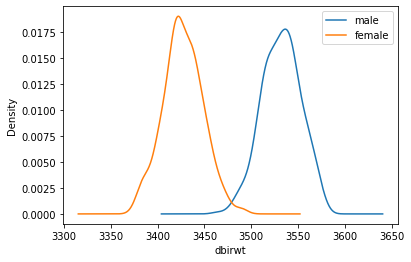

In [74]:
SM640 = mean_density_comparison(df, M=500, n=640)

In [12]:
grouped640 = SM640["dbirwt"].groupby(SM640["sex"])

print("n=640, means:", grouped640.mean())
print()
print("n=640, SESMs:", grouped640.std())

n=640, means: sex
female    3427.276397
male      3533.081803
Name: dbirwt, dtype: float64

n=640, SESMs: sex
female    20.937106
male      19.819436
Name: dbirwt, dtype: float64


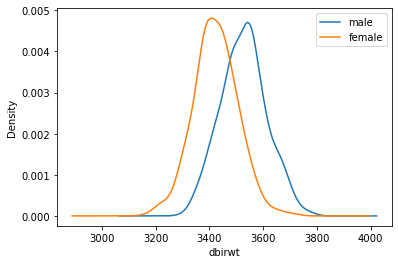

In [13]:
SM40 = mean_density_comparison(df, M=500, n=40)

In [14]:
grouped40 = SM40["dbirwt"].groupby(SM40["sex"])

print("n=40, means:", grouped40.mean())
print()
print("n=40, SESMs:", grouped40.std())

n=40, means: sex
female    3423.30740
male      3527.34015
Name: dbirwt, dtype: float64

n=40, SESMs: sex
female    82.787145
male      84.921927
Name: dbirwt, dtype: float64


How much smaller is $\sigma_{\bar{x},640}$ than $\sigma_{\bar{x},40}$ ?
Compare that factor to the ratio of the sample sizes $640/40 = 16$

----------
### Empirical Cumulative Distribution Function

The density -like a histogram- has a few complications that include the arbitrary choice of bin width (kernel width for density) and the loss of information. Welcome to the *empirical cumulative distribution function* **ecdf**

-------
**ECDF Function**

In [15]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

---------
**ECDF Plot**

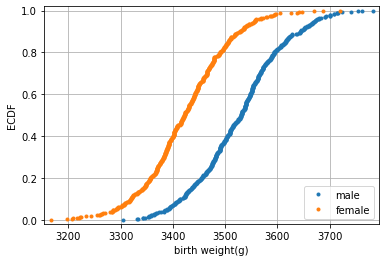

In [16]:
# Compute ECDF for sample size 40: m_40, f_40
male40 = SM40[SM40.sex == "male"]["dbirwt"]
female40 = SM40[SM40.sex == "female"]["dbirwt"]

mx_40, my_40 = ecdf(male40)
fx_40, fy_40 = ecdf(female40)

# Plot all ECDFs on the same plot
fig, ax = plt.subplots()
_ = ax.plot(mx_40, my_40, marker = '.', linestyle = 'none')
_ = ax.plot(fx_40, fy_40, marker = '.', linestyle = 'none')

# Make nice margins
plt.margins(0.02)

# Annotate the plot
plt.legend(('male', 'female'), loc='lower right')
_ = plt.xlabel('birth weight(g)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.grid()
plt.show()

--------------------------------------------------------------
- What is the relationship to quantiles/percentiles ?
- Find the IQR !
- Sketch the densities just from the ecdf.

----------
### Checking Normality of sample mean distribution

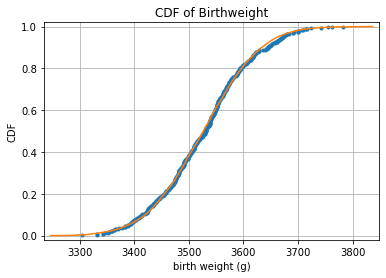

In [17]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(male40)
sigma = np.std(male40)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)

# Plot the CDFs and show the plot
_ = plt.plot(mx_40, my_40, marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor)

plt.margins(0.02)
_ = plt.xlabel('birth weight (g)')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of Birthweight')

plt.grid()
plt.show()

**Tasks**
1. Find the "5% tails" which are just the (0.05, 0.95) quantiles 
2. Read up on theoretical quantiles: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
3. stone age: get the "5% tails" from a normal table.
4. How many stdevs do you need to cover the 90% sample interval ?
5. Can you replace the "empirical theoretical cdf" from above with the exact line without sampling 10000 random numbers from a normal distribution ?

--------------------------------------------------------------
Let us recap what we observed when sampling from a "population": The *sample mean distribution* gets narrower with increasing sample size n, SESM =$\sigma_{\bar{x}} = \sigma/\sqrt{n}$.
Take a look at this [interactive applet](http://onlinestatbook.com/stat_sim/sampling_dist/) for further understanding.

How is this useful ? And how is it relevant because in reality we would only have **one sample**, not hundreds !

**Small Tasks**

1. Choose one random sample of size n=40 from the male babies and compute $\bar{x}$, $\hat{\sigma}$. Assume all that is known to you, are these two *summary statistics*. In particular, we do **not know** the true mean $\mu$!
2. Argue intuitively with the ecdf plot about plausible values of $\mu$.
3. More precisely: what interval around $\bar{x}$ would contain $\mu$ with 90% probability ?

----
## Hacker Statistic

The ability to draw new samples from a population with a known mean is a luxury that we usually do not have. Is there any way to "fake" new samples using just the one "lousy" sample we have at hand ? 
This might sound like an impossible feat analogously to "pulling yourself up by your own **bootstraps**"!

![BootstrapIlustration](../figures/DC_bootstrap_animated.gif  "segment")

But that is exactly what we will try now:

**Tasks**
1. Look up the help for [np.random.choice()](https://docs.scipy.org/doc/numpy15.0/reference/generated/numpy.random.choice.html)
<br>
2. Draw repeated samples of size n=40 from the sample above.
3. Compute the mean of each sample and store it an array.
4. Plot the histogram
5. Compute the stdev of this distribution and compare to the SEM.
<br>
6. Write a function that computes *bootstrap replicates* of the mean from a sample.
7. Generalize this function to accept any summary statistic, not just the mean.

-----
2. Draw repeated samples of size n=40 from the sample above.
3. Compute the mean of each sample and store it an array.
4. Plot the histogram
5. Compute the stdev of this distribution and compare to the SEM.

In [18]:
def draw_bs_reps_mean(data, size=100):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = np.mean(np.random.choice(data, size=len(data)))

    return bs_replicates

-----
4. Plot the histogram
5. Compute the stdev of this distribution and compare to the SEM.

STDEV: 0.8246957554773897


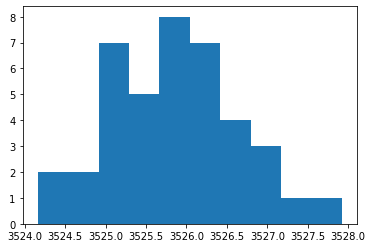

In [19]:
data = draw_bs_reps_mean(data=samples, size=40)
plt.hist(x=data);
print(f"STDEV: {np.std(data)}")


-----
6. Write a function that computes *bootstrap replicates* of the mean from a sample.
7. Generalize this function to accept any summary statistic, not just the mean.

In [20]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func = np.mean, size=100):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [21]:
subset = df[df.sex == "male"]
rand_samples_40 = np.random.choice(subset.dbirwt, 40)
xBar = np.mean(rand_samples_40)
rand_samples_40

array([3798, 3515, 2919, 4110, 3769, 2636, 4172, 3118, 2636, 3600, 3260,
       2948, 2749, 3713, 3486, 4280, 4253, 2998, 2863, 3260, 3273, 4409,
       3345, 4139, 2352, 3572, 4053, 3515, 3572, 3968, 3260, 4689, 3781,
       2948, 2494, 2948, 3430, 2296, 3969, 3883])

In [22]:
# Take 1,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rand_samples_40, np.mean, size=1000)

In [23]:
bs_replicates[0:10]

array([3536.425, 3361.85 , 3587.775, 3257.925, 3533.35 , 3520.325,
       3520.275, 3314.375, 3389.275, 3520.75 ])

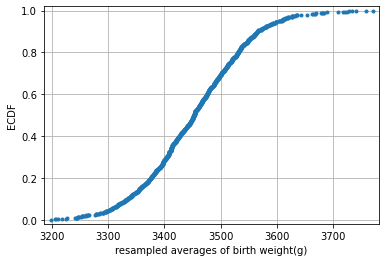

In [24]:
fx_40, fy_40 = ecdf(bs_replicates)

# Plot  ECDF
_ = plt.plot(fx_40, fy_40, marker = '.', linestyle = 'none')

# Make nice margins
plt.margins(0.02)

# Annotate the plot
_ = plt.xlabel('resampled averages of birth weight(g)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.grid()
plt.show()